In [1]:
%%capture
#@markdown # DeepLab training
!python -m pip install onnx
!python -m pip install ultralytics
!python -m pip install abraia==0.16.0

import os
if not os.getenv('ABRAIA_ID') and not os.getenv('ABRAIA_KEY'):
    abraia_id = ''  #@param {type: "string"}
    abraia_key = ''  #@param {type: "string"}
    %env ABRAIA_ID=$abraia_id
    %env ABRAIA_KEY=$abraia_key

from abraia import training, detect

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6.74M/6.74M [00:00<00:00, 122MB/s]
100%|██████████| 755k/755k [00:00<00:00, 17.7MB/s]
100%|██████████| 6.25M/6.25M [00:00<00:00, 106MB/s]
train: Scanning /content/screws/train/labels... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<00:00, 411.06it/s]
/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/screws/val/labels... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<00:00, 133.64it/s]
       1/50     0.751G     0.7506      2.121      3.108      1.115         71        640: 100%|██████████| 1/1 [00:06<00:00,  6.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50

runs/segment/train2
screws/test/images/001.png [{'label': 'bad', 'confidence': 0.273723840713501, 'box': [171.7744140625, 143.2366943359375, 700.75048828125, 753.0108032226562], 'polygon': [(371.2, 144.0), (371.2, 148.8), (368.0, 152.0), (366.4, 152.0), (361.6, 156.8), (360.0, 156.8), (358.4, 158.4), (355.2, 158.4), (353.6, 160.0), (352.0, 160.0), (345.6, 166.4), (344.0, 166.4), (339.2, 171.2), (337.6, 171.2), (334.4, 174.4), (332.8, 174.4), (328.0, 179.2), (326.4, 179.2), (320.0, 185.6), (318.4, 185.6), (312.0, 192.0), (310.4, 192.0), (305.6, 196.8), (304.0, 196.8), (300.8, 200.0), (299.2, 200.0), (289.6, 209.6), (288.0, 209.6), (281.6, 216.0), (280.0, 216.0), (267.2, 228.8), (265.6, 228.8), (252.8, 241.6), (251.2, 241.6), (227.2, 265.6), (225.6, 265.6), (217.6, 273.6), (217.6, 275.2), (203.2, 289.6), (203.2, 291.2), (198.4, 296.0), (198.4, 297.6), (193.6, 302.4), (193.6, 304.0), (192.0, 305.6), (192.0, 307.2), (190.4, 308.8), (190.4, 310.4), (187.2, 313.6), (187.2, 323.2), (190.4, 32

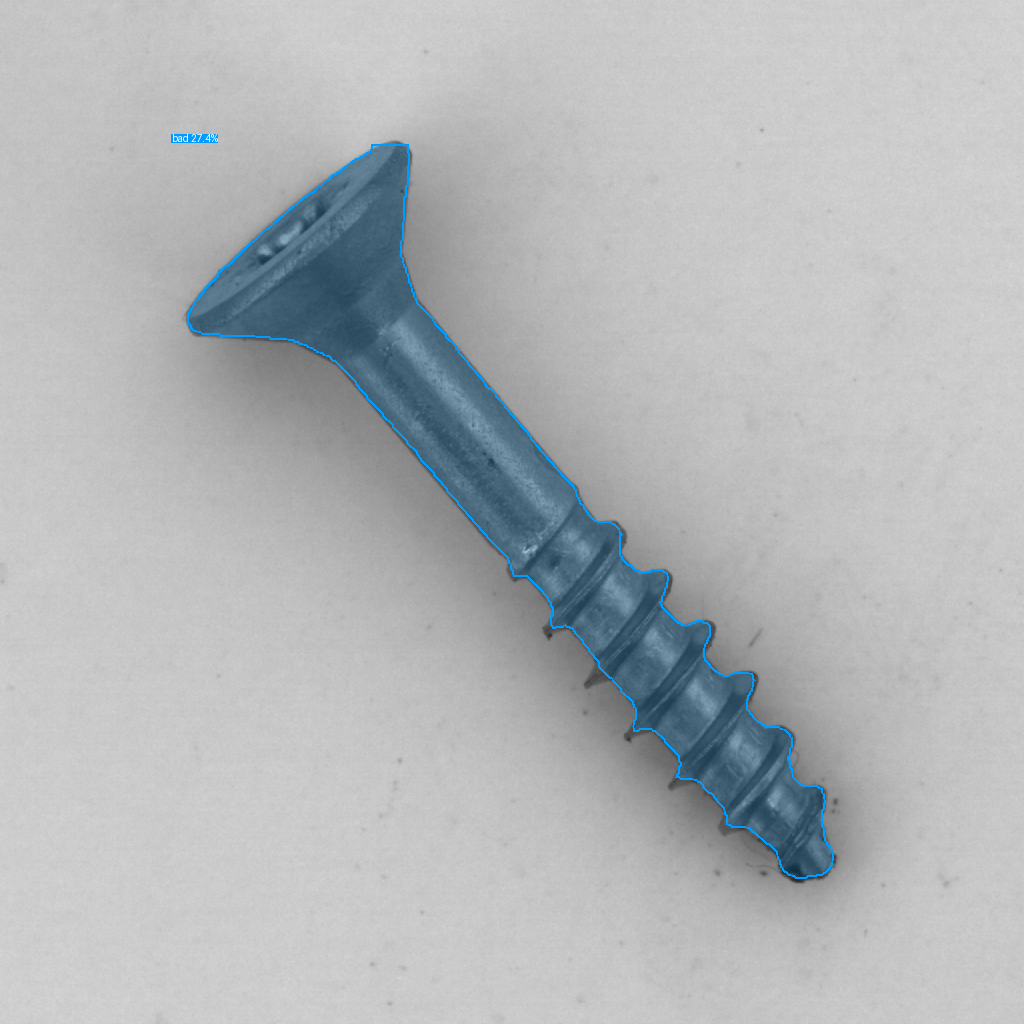

In [2]:
#@markdown ## Dashboard

import glob
import itertools
from PIL import Image
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image as show_image

def sorted_folders(dir):
    items = [os.path.join(dir, name) for name in os.listdir(dir)]
    sorted_items = sorted(items, key=os.path.getctime)
    return sorted_items

def source_images(dir):
    return list(itertools.chain.from_iterable([glob.glob(f"{dir}*/*.{ext}") for ext in ['png', 'jpg']]))

projects = training.load_projects()

dropdown_project = widgets.Dropdown(description='Project', options=projects, value=projects[0])
text_classes = widgets.Text(description='Classes', value='')
text_task = widgets.Text(description='Task', value='')
label_status = widgets.Label(value='')

def dropdown_project_eventhandler(change):
    output_train.clear_output()
    output_labels.clear_output()
    output_pred.clear_output()
    label_status.value = 'Loading annotations...'
    dataset = dropdown_project.value
    annotations = training.load_annotations(dataset)
    classes = training.load_labels(annotations)
    task = training.load_task(annotations)
    text_classes.value = str(classes or '')
    text_task.value = str(task or '')
    if len(classes) and task:
        label_status.value = 'Annotations loaded.'
        button_train.disabled = False
    else:
        label_status.value = 'Not annotated.'
        button_train.disabled = True

dropdown_project.observe(dropdown_project_eventhandler, names='value')

button_train = widgets.Button(description='Train', disabled=True)
output_train = widgets.Output(layout={'border': '1px solid black', 'width': '50%', 'height': '360px', 'overflow': 'auto'})

output_labels = widgets.Output()
output_pred = widgets.Output()

def button_train_eventhandler(obj):
    #output_train.clear_output()
    #with output_train:
    button_train.disabled = True
    dataset = dropdown_project.value
    classes = eval(text_classes.value)
    task = text_task.value
    epochs = 50
    imgz = 640
    #model_type = dropdown_type.value
    #batch_size = 32
    if not os.path.exists(dataset):
        label_status.value = 'Creating dataset...'
        training.create_dataset(dataset, task, classes)
    label_status.value = 'Dataset created.'
    if task == 'classify':
        model_name = 'model_ft'
        training_session = training.classify.Model()
        dataloaders, classes = training_session.create_dataset(dataset)
        label_status.value = 'Training model...'
        model = training_session.train(dataset)
        training_session.save(dataset, classes)
        label_status.value = 'Model saved.'
        with output_labels:
            display(training.classify.visualize_data(dataloaders['train']))
        #training.classify.visualize_model(model, dataloaders['val'])
    else:
        label_status.value = 'Training model...'
        training_session = training.detect.Model(task)
        metrics = training_session.train(dataset, epochs=epochs, imgsz=imgz)
        training_session.save(dataset, classes, imgsz=imgz)
        label_status.value = 'Model saved.'
        folder = sorted_folders(f"runs/{task}/")[-1]
        print(folder)
        with output_labels:
            display(show_image(filename=f"{folder}/val_batch0_labels.jpg"))
        with output_pred:
            display(show_image(filename=f"{folder}/val_batch0_pred.jpg"))
    src = source_images(f"{dataset}/test/")[0]
    im = Image.open(src).convert('RGB')
    results = training_session.run(im)
    print(src, results)
    display(detect.render_results(im, results))
    button_train.disabled = False

button_train.on_click(button_train_eventhandler)

hbox_output = widgets.HBox([output_labels, output_pred])
#hbox_output = widgets.HBox([output_train, output_labels, output_pred])
dashboard = widgets.VBox([dropdown_project, text_classes, text_task, label_status, button_train, hbox_output])
display(dashboard)